# Parallel pathways model
We give another go at the estimation of highest flux paths using a slightly more complicated model involving six states. I adapt the ```Fourstate``` class so that we can do the same exact thing as before. The model system looks like the following.

<img src="files/parallel.png">

### Initialization
As before we initialize the system producing the transition count matrix ($\mathbf{N}$), transition probability matrix ($\mathbf{T}$) and rate matrix ($\mathbf{K}$). I slightly modify the values in the count matrix preserving its topology, so that not all numbers are equal.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import parallel
import itertools
import networkx as nx
import numpy as np
bhs = parallel.Parallel()


 count matrix:
[[26000     5     2     0     0     0]
 [    5  4000     1     3     2     0]
 [    2     1  1500     2     2     0]
 [    0     3     2  1000     1     2]
 [    0     2     2     1  2000    10]
 [    0     0     0     2    10 59000]]

 transition matrix:
[[  9.99730842e-01   1.24657193e-03   1.32714001e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.92255931e-04   9.97257542e-01   6.63570007e-04   2.97619048e-03
    9.92555831e-04   0.00000000e+00]
 [  7.69023724e-05   2.49314385e-04   9.95355010e-01   1.98412698e-03
    9.92555831e-04   0.00000000e+00]
 [  0.00000000e+00   7.47943156e-04   1.32714001e-03   9.92063492e-01
    4.96277916e-04   3.38914119e-05]
 [  0.00000000e+00   4.98628771e-04   1.32714001e-03   9.92063492e-04
    9.92555831e-01   1.69457060e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.98412698e-03
    4.96277916e-03   9.99796652e-01]]

 rate:
[[ -2.69158304e-04   1.24657193e-03   1.32714001e-03   0.00000000e+00
    0.0

Again, the system exhibits a time scale separation between the first and second modes as we would expect.

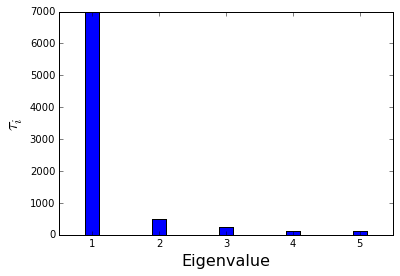

In [9]:
fig, ax = plt.subplots()
ax.bar([x+0.9 for x in range(5)], -1./bhs.evals[1:], width=0.2)
ax.set_xlabel(r'Eigenvalue', fontsize=16)
ax.set_ylabel(r'$\tau_i$', fontsize=18)
ax.set_xlim([0.5,5.5])
plt.show()

###Committors and reactive flux

In [10]:
bhs.run_commit()


 pfold values:
[ 0.          0.35204478  0.4534287   0.59710776  0.81387032  1.        ]

 flux :
[[ -0.00000000e+00  -1.88138512e-05  -9.69278975e-06  -0.00000000e+00
   -0.00000000e+00  -0.00000000e+00]
 [  1.88138512e-05  -0.00000000e+00  -1.08362464e-06  -7.85794067e-06
   -9.87228586e-06  -0.00000000e+00]
 [  9.69278975e-06   1.08362464e-06  -0.00000000e+00  -3.07137782e-06
   -7.70503657e-06  -0.00000000e+00]
 [  0.00000000e+00   7.85794067e-06   3.07137782e-06  -0.00000000e+00
   -2.31682938e-06  -8.61248911e-06]
 [  0.00000000e+00   9.87228586e-06   7.70503657e-06   2.31682938e-06
   -0.00000000e+00  -1.98941518e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.61248911e-06
    1.98941518e-05  -0.00000000e+00]]

 reactive flux: 2.85066e-05


We check for the property of flux conservation, i.e. $J_j=\sum_{p_{fold}(i)<p_{fold}(j)}J_{i\rightarrow j}=\sum_{p_{fold}(i)>p_{fold}(j)}J_{j\rightarrow i}$.

In [11]:
print " j   J_j(<-)    J_j(->)"
print " -  --------   --------"
for i in range(1,5):
    print "%2i %10.4e %10.4e"%(i, np.sum([bhs.J[i,x] for x in range(6) if bhs.pfold[x] < bhs.pfold[i]]),\
                               np.sum([bhs.J[x,i] for x in range(6) if bhs.pfold[x] > bhs.pfold[i]]))

 j   J_j(<-)    J_j(->)
 -  --------   --------
 1 1.8814e-05 1.8814e-05
 2 1.0776e-05 1.0776e-05
 3 1.0929e-05 1.0929e-05
 4 1.9894e-05 1.9894e-05


Once that we have checked for this, we can now generate paths.

In [12]:
import tpt_functions

Jnode, Jpath = tpt_functions.gen_path_lengths(range(6), bhs.J, bhs.pfold, \
                                bhs.sum_flux, [5], [0])
JpathG = nx.DiGraph(Jpath.transpose())

In [13]:
tot_flux = 0
for path in nx.all_simple_paths(JpathG, 0, 5):
    print path
    f = bhs.J[path[1],path[0]]
    print "%2i -> %2i: %10.4e "%(path[0], path[1], \
                bhs.J[path[1],path[0]])
    for i in range(2, len(path)):
        print "%2i -> %2i: %10.4e %10.4e"%(path[i-1], path[i], \
                bhs.J[path[i],path[i-1]], Jnode[path[i-1]])
        f *= bhs.J[path[i],path[i-1]]/Jnode[path[i-1]]
    tot_flux +=f
    print "  J(path) = %10.4e"%f
    print
print " Commulative flux: %10.4e"%tot_flux

[0, 1, 2, 3, 4, 5]
 0 ->  1: 1.8814e-05 
 1 ->  2: 1.0836e-06 1.8814e-05
 2 ->  3: 3.0714e-06 1.0776e-05
 3 ->  4: 2.3168e-06 1.0929e-05
 4 ->  5: 1.9894e-05 1.9894e-05
  J(path) = 6.5469e-08

[0, 1, 2, 3, 5]
 0 ->  1: 1.8814e-05 
 1 ->  2: 1.0836e-06 1.8814e-05
 2 ->  3: 3.0714e-06 1.0776e-05
 3 ->  5: 8.6125e-06 1.0929e-05
  J(path) = 2.4337e-07

[0, 1, 2, 4, 5]
 0 ->  1: 1.8814e-05 
 1 ->  2: 1.0836e-06 1.8814e-05
 2 ->  4: 7.7050e-06 1.0776e-05
 4 ->  5: 1.9894e-05 1.9894e-05
  J(path) = 7.7478e-07

[0, 1, 3, 4, 5]
 0 ->  1: 1.8814e-05 
 1 ->  3: 7.8579e-06 1.8814e-05
 3 ->  4: 2.3168e-06 1.0929e-05
 4 ->  5: 1.9894e-05 1.9894e-05
  J(path) = 1.6657e-06

[0, 1, 3, 5]
 0 ->  1: 1.8814e-05 
 1 ->  3: 7.8579e-06 1.8814e-05
 3 ->  5: 8.6125e-06 1.0929e-05
  J(path) = 6.1922e-06

[0, 1, 4, 5]
 0 ->  1: 1.8814e-05 
 1 ->  4: 9.8723e-06 1.8814e-05
 4 ->  5: 1.9894e-05 1.9894e-05
  J(path) = 9.8723e-06

[0, 2, 3, 4, 5]
 0 ->  2: 9.6928e-06 
 2 ->  3: 3.0714e-06 1.0776e-05
 3 ->  4: 2.3168e

According to the enumeration of paths, the highest flux paths would be:

1. 0$\rightarrow$1$\rightarrow$4$\rightarrow$5; $J=$9.87e-06
2. 0$\rightarrow$2$\rightarrow$4$\rightarrow$5; $J=$6.93e-06
3. 0$\rightarrow$1$\rightarrow$3$\rightarrow$5; $J=$6.19e-06
4. 0$\rightarrow$2$\rightarrow$3$\rightarrow$5; $J=$2.18e-06


###Highest flux paths
Again, we check whether we can get the hierarchy of paths by removing the flux from the edges of the graph involved in the highest flux paths.

In [14]:
while True:
    Jnode, Jpath = tpt_functions.gen_path_lengths(range(6), bhs.J, bhs.pfold, \
                                     bhs.sum_flux, [5], [0])
    # generate nx graph from matrix
    JpathG = nx.DiGraph(Jpath.transpose())
    # find shortest path
    try:
        path = nx.dijkstra_path(JpathG, 0, 5)
        pathlength = nx.dijkstra_path_length(JpathG, 0, 5)
        print " shortest path:", path, pathlength
    except nx.NetworkXNoPath:
        print " No path for %g -> %g\n Stopping here"%(0, 5)
        break
    
    # calculate contribution to flux
    f = bhs.J[path[1],path[0]]
    print "%2i -> %2i: %10.4e "%(path[0], path[1], bhs.J[path[1],path[0]])
    path_fluxes = [f]
    for j in range(2, len(path)):
        i = j - 1
        print "%2i -> %2i: %10.4e %10.4e"%(path[i], path[j], \
            bhs.J[path[j],path[i]], \
            bhs.J[path[j],path[i]]/Jnode[path[i]])
        f *= bhs.J[path[j],path[i]]/Jnode[path[i]]
        path_fluxes.append(bhs.J[path[j],path[i]])

    # find bottleneck
    ib = np.argmin(path_fluxes)
    print "bottleneck: %2i -> %2i"%(path[ib],path[ib+1])
        
    # remove flux from edges
    for j in range(1,len(path)):
        i = j - 1
        bhs.J[path[j],path[i]] -= f
    #bhs.J[path[ib],path[ib+1]] -= f
        
    # numerically there may be some leftover flux in bottleneck
    #bhs.J[path[ib],path[ib+1]] = 0.
    
    bhs.sum_flux -= f
    print ' flux from path ', path, ': %10.4e'%f
    print ' fluxes', path_fluxes
    print ' leftover flux: %10.4e; %10.2f  \n'%(bhs.sum_flux, bhs.sum_flux/tot_flux)
    if bhs.sum_flux/tot_flux < 0.01:
        break

 shortest path: [0, 1, 4, 5] 1.06040565451
 0 ->  1: 1.8814e-05 
 1 ->  4: 9.8723e-06 5.2473e-01
 4 ->  5: 1.9894e-05 1.0000e+00
bottleneck:  1 ->  4
 flux from path  [0, 1, 4, 5] : 9.8723e-06
 fluxes [1.881385116940691e-05, 9.8722858609786206e-06, 1.9894151810760102e-05]
 leftover flux: 1.8634e-05;       0.65  

 shortest path: [0, 2, 4, 5] 0.989110319992
 0 ->  2: 9.6928e-06 
 2 ->  4: 7.7050e-06 7.1499e-01
 4 ->  5: 1.0022e-05 1.0000e+00
bottleneck:  2 ->  4
 flux from path  [0, 2, 4, 5] : 6.9303e-06
 fluxes [9.6927897544152864e-06, 7.7050365743260838e-06, 1.0021865949781416e-05]
 leftover flux: 1.1704e-05;       0.41  

 shortest path: [0, 1, 3, 5] 0.636650223097
 0 ->  1: 8.9416e-06 
 1 ->  3: 7.8579e-06 8.7881e-01
 3 ->  5: 8.6125e-06 7.8802e-01
bottleneck:  1 ->  3
 flux from path  [0, 1, 3, 5] : 6.1922e-06
 fluxes [8.9415653084282235e-06, 7.8579406651021719e-06, 8.6124891130625465e-06]
 leftover flux: 5.5119e-06;       0.19  

 shortest path: [0, 2, 3, 5] 1.58725143922
 0 ->  2

Here we find that the elimination of flux from edges fails to reproduce the correct order of paths as obtained from the exhaustive enumeration.